# Ant Colony Optimization (ACO) Development for Air Quality Prediction

This notebook implements and tests the ACO feature selection algorithm for air quality prediction.

## Objectives
1. Test ACO implementation on transformed AQI data
2. Optimize ACO parameters for best performance
3. Compare ACO+DT with Random Forest baseline
4. Analyze feature selection patterns and policy relevance
5. Generate convergence plots and performance visualizations


In [14]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import os
import sys
import joblib
import json

# Add src directory to path
src_path = os.path.abspath('../src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import ACO optimizer
try:
    from aco_optimizer import ACO_FeatureSelection
    print("ACO optimizer imported successfully")
except ImportError as e:
    print(f"Import error: {e}")
    print(f"Looking for aco_optimizer.py in: {src_path}")
    print(f"Files in src directory: {os.listdir(src_path) if os.path.exists(src_path) else 'Directory not found'}")

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("ACO development libraries imported successfully")


ACO optimizer imported successfully
ACO development libraries imported successfully


In [15]:
# Load and transform AQI data for ACO testing
print("Loading original AQI data...")
df_original = pd.read_csv('../data/raw/aqi.csv')

print(f"Original dataset shape: {df_original.shape}")
print(f"Original columns: {list(df_original.columns)}")

# Check if transformed data exists
try:
    df_aco = pd.read_csv('../data/processed/aqi_transformed_for_aco.csv')
    if len(df_aco) == 0:
        raise ValueError("Transformed data is empty")
    print("Using existing transformed data")
except:
    print("Transforming data for ACO...")
    
    def transform_aqi_data_for_aco(df, target_cities=None):
        """Transform AQI data from prominent pollutant format to tabular format for ACO"""
        
        # Filter for target cities if specified
        if target_cities:
            df = df[df['area'].isin(target_cities)].copy()
        
        # Convert date column
        df['date'] = pd.to_datetime(df['date'])
        
        # Create temporal features
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
        df['day_of_week'] = df['date'].dt.dayofweek
        df['day_of_year'] = df['date'].dt.dayofyear
        df['season'] = df['month'].map({12:1, 1:1, 2:1,  # Winter
                                       3:2, 4:2, 5:2,   # Spring
                                       6:3, 7:3, 8:3,   # Summer
                                       9:4, 10:4, 11:4}) # Fall
        
        # Create cyclical encoding for temporal features
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
        df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
        df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
        df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
        
        # Simulate pollutant concentrations based on AQI and prominent pollutants
        pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']
        
        for pollutant in pollutants:
            # Create concentration estimates based on AQI and prominent pollutant
            base_concentration = df['aqi_value'] * np.random.uniform(0.8, 1.2, len(df))
            
            # If this pollutant is prominent, give it higher concentration
            is_prominent = df['prominent_pollutants'].str.contains(pollutant, na=False)
            concentration = np.where(is_prominent, 
                                  base_concentration * np.random.uniform(1.2, 1.8),
                                  base_concentration * np.random.uniform(0.3, 0.8))
            
            df[f'{pollutant}_concentration'] = concentration
        
        # Simulate weather features (since they're not in the original dataset)
        np.random.seed(42)  # For reproducibility
        df['temperature'] = np.random.normal(25, 8, len(df))  # Mean 25°C, std 8°C
        df['humidity'] = np.random.uniform(40, 90, len(df))    # 40-90% humidity
        df['wind_speed'] = np.random.uniform(5, 25, len(df))  # 5-25 km/h
        df['pressure'] = np.random.normal(1013, 20, len(df))  # Mean 1013 hPa
        
        # Create lag features (previous day values)
        df_sorted = df.sort_values(['area', 'date']).reset_index(drop=True)
        
        for pollutant in pollutants:
            df_sorted[f'{pollutant}_lag1'] = df_sorted.groupby('area')[f'{pollutant}_concentration'].shift(1)
            df_sorted[f'{pollutant}_lag2'] = df_sorted.groupby('area')[f'{pollutant}_concentration'].shift(2)
        
        df_sorted['aqi_lag1'] = df_sorted.groupby('area')['aqi_value'].shift(1)
        df_sorted['aqi_lag2'] = df_sorted.groupby('area')['aqi_value'].shift(2)
        
        # Create rolling averages
        for pollutant in pollutants:
            df_sorted[f'{pollutant}_rolling3'] = df_sorted.groupby('area')[f'{pollutant}_concentration'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)
            df_sorted[f'{pollutant}_rolling7'] = df_sorted.groupby('area')[f'{pollutant}_concentration'].rolling(7, min_periods=1).mean().reset_index(0, drop=True)
        
        df_sorted['aqi_rolling3'] = df_sorted.groupby('area')['aqi_value'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)
        df_sorted['aqi_rolling7'] = df_sorted.groupby('area')['aqi_value'].rolling(7, min_periods=1).mean().reset_index(0, drop=True)
        
        # Create ratio features
        df_sorted['PM25_PM10_ratio'] = df_sorted['PM2.5_concentration'] / (df_sorted['PM10_concentration'] + 1e-6)
        df_sorted['NO2_SO2_ratio'] = df_sorted['NO2_concentration'] / (df_sorted['SO2_concentration'] + 1e-6)
        
        # Create interaction terms
        df_sorted['PM25_temp_interaction'] = df_sorted['PM2.5_concentration'] * df_sorted['temperature']
        df_sorted['PM10_humidity_interaction'] = df_sorted['PM10_concentration'] * df_sorted['humidity']
        df_sorted['NO2_wind_interaction'] = df_sorted['NO2_concentration'] * df_sorted['wind_speed']
        
        # Remove rows with NaN values (from lag features)
        df_sorted = df_sorted.dropna().reset_index(drop=True)
        
        return df_sorted
    
    # Transform the data
    target_cities = ['Delhi', 'Mumbai', 'Bangalore', 'Kolkata', 'Hyderabad', 'Chennai']
    df_aco = transform_aqi_data_for_aco(df_original, target_cities)
    
    # Save transformed data
    df_aco.to_csv('../data/processed/aqi_transformed_for_aco.csv', index=False)
    print("Transformed data saved successfully")

print(f"Transformed dataset shape: {df_aco.shape}")
print(f"Transformed dataset columns: {list(df_aco.columns)}")

# Separate features and target
feature_columns = [col for col in df_aco.columns if col not in ['area', 'date', 'aqi_value', 'state', 'number_of_monitoring_stations', 'prominent_pollutants', 'air_quality_status', 'unit', 'note']]
X = df_aco[feature_columns]
y = df_aco['aqi_value']

print(f"Features: {len(feature_columns)}")
print(f"Target variable: aqi_value")
print(f"Sample size: {len(X)}")

# Display feature categories
policy_controllable = [col for col in feature_columns if any(pollutant in col for pollutant in ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3'])]
weather_features = [col for col in feature_columns if col in ['temperature', 'humidity', 'wind_speed', 'pressure']]
temporal_features = [col for col in feature_columns if col in ['year', 'month', 'day', 'day_of_week', 'day_of_year', 'season']]

print(f"\nFeature Categories:")
print(f"  Policy-controllable features: {len(policy_controllable)}")
print(f"  Weather features: {len(weather_features)}")
print(f"  Temporal features: {len(temporal_features)}")
print(f"  Other features: {len(feature_columns) - len(policy_controllable) - len(weather_features) - len(temporal_features)}")


Loading original AQI data...
Original dataset shape: (235785, 9)
Original columns: ['date', 'state', 'area', 'number_of_monitoring_stations', 'prominent_pollutants', 'aqi_value', 'air_quality_status', 'unit', 'note']
Using existing transformed data
Transformed dataset shape: (1876, 57)
Transformed dataset columns: ['date', 'state', 'area', 'number_of_monitoring_stations', 'prominent_pollutants', 'aqi_value', 'air_quality_status', 'unit', 'note', 'PM2.5_concentration', 'PM10_concentration', 'NO2_concentration', 'SO2_concentration', 'CO_concentration', 'O3_concentration', 'year', 'month', 'day', 'day_of_week', 'day_of_year', 'season', 'temperature', 'humidity', 'wind_speed', 'pressure', 'PM2.5_lag1', 'PM10_lag1', 'NO2_lag1', 'SO2_lag1', 'CO_lag1', 'O3_lag1', 'PM2.5_lag2', 'PM10_lag2', 'NO2_lag2', 'SO2_lag2', 'CO_lag2', 'O3_lag2', 'PM2.5_lag3', 'PM10_lag3', 'NO2_lag3', 'SO2_lag3', 'CO_lag3', 'O3_lag3', 'PM2.5_avg3', 'PM2.5_avg7', 'PM10_avg3', 'PM10_avg7', 'NO2_avg3', 'NO2_avg7', 'SO2_avg3

In [16]:
# Initialize ACO Feature Selection and Run Optimization
print("Initializing ACO Feature Selection...")

# Initialize ACO optimizer with improved parameters
aco_optimizer = ACO_FeatureSelection(
    n_ants=100,        # More ants for better exploration
    n_iterations=150,  # More iterations for convergence
    alpha=1.2,         # Higher pheromone importance
    beta=1.8,          # Balanced heuristic importance
    rho=0.05,          # Lower evaporation for stronger trails
    q0=0.8,            # More exploration vs exploitation
    policy_weight=1.3, # Slightly reduced policy bias
    min_features=8,    # More minimum features
    max_features=25    # Allow more features for better accuracy
)

print(f"ACO optimizer initialized with {len(feature_columns)} features")
print(f"Feature selection range: {aco_optimizer.min_features} to {aco_optimizer.max_features} features")

# Run ACO Feature Selection
print("\nRunning ACO Feature Selection...")
print("This may take several minutes...")

# Run ACO optimization (it handles train/test split internally)
results = aco_optimizer.optimize(
    X, y, 
    test_size=0.2,
    random_state=42
)

# Extract results
best_features = results['best_features']
convergence_history = results['convergence_history']

# Create train/test split for model comparison (using same random_state for consistency)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nACO Optimization Complete!")
print(f"Selected {len(best_features)} features out of {len(feature_columns)}")
print(f"Feature reduction: {((len(feature_columns) - len(best_features)) / len(feature_columns) * 100):.1f}%")

# Display selected features
print(f"\nSelected Features:")
for i, feature in enumerate(best_features, 1):
    if any(pollutant in feature for pollutant in aco_optimizer.policy_controllable):
        category = "Policy-controllable"
    elif any(weather in feature.lower() for weather in ['temperature', 'humidity', 'wind', 'pressure']):
        category = "Weather"
    else:
        category = "Other"
    print(f"  {i:2d}. {feature} ({category})")


INFO:aco_optimizer:Starting ACO feature selection optimization
INFO:aco_optimizer:Available features for selection: 48
INFO:aco_optimizer:Iteration 1/150


Initializing ACO Feature Selection...
ACO optimizer initialized with 48 features
Feature selection range: 8 to 25 features

Running ACO Feature Selection...
This may take several minutes...


INFO:aco_optimizer:New best solution found: 8 features, fitness: 5.8697
INFO:aco_optimizer:Iteration 2/150
INFO:aco_optimizer:New best solution found: 8 features, fitness: 5.8684
INFO:aco_optimizer:Iteration 3/150
INFO:aco_optimizer:Iteration 4/150
INFO:aco_optimizer:Iteration 5/150
INFO:aco_optimizer:Iteration 6/150
INFO:aco_optimizer:Iteration 7/150
INFO:aco_optimizer:Iteration 8/150
INFO:aco_optimizer:Iteration 9/150
INFO:aco_optimizer:Iteration 10/150
INFO:aco_optimizer:Iteration 11/150
INFO:aco_optimizer:Iteration 12/150
INFO:aco_optimizer:Early stopping: No improvement for 10 iterations
INFO:aco_optimizer:Optimization completed. Best solution: 8 features
INFO:aco_optimizer:Test RMSE: 94.3806, MAE: 66.6230, R²: 0.0623



ACO Optimization Complete!
Selected 8 features out of 48
Feature reduction: 83.3%

Selected Features:
   1. PM10_concentration (Policy-controllable)
   2. NO2_concentration (Policy-controllable)
   3. O3_concentration (Policy-controllable)
   4. PM2.5_concentration (Policy-controllable)
   5. CO_concentration (Policy-controllable)
   6. PM10_avg3 (Policy-controllable)
   7. PM2.5_lag1 (Policy-controllable)
   8. PM2.5_avg3 (Policy-controllable)


In [17]:
# Train Enhanced Models and Evaluate Performance
print("Training enhanced models for comparison...")

# Train Enhanced ACO+Decision Tree Ensemble on selected features
dt_aco_ensemble = BaggingRegressor(
    estimator=DecisionTreeRegressor(
        max_depth=15,           # Deeper tree for more complexity
        min_samples_split=10,   # Allow more splits
        min_samples_leaf=5,     # Smaller leaves for detail
        min_impurity_decrease=0.001,  # Allow small improvements
        max_features='sqrt',    # Feature sampling for robustness
        random_state=42
    ),
    n_estimators=50,            # 50 trees in ensemble
    max_samples=0.8,            # Bootstrap sampling
    max_features=1.0,           # Use all ACO-selected features
    random_state=42,
    n_jobs=-1
)
dt_aco_ensemble.fit(X_train[best_features], y_train)

# Also train single enhanced Decision Tree for comparison
dt_aco = DecisionTreeRegressor(
    max_depth=15,           # Deeper tree for more complexity
    min_samples_split=10,   # Allow more splits
    min_samples_leaf=5,     # Smaller leaves for detail
    min_impurity_decrease=0.001,  # Allow small improvements
    max_features='sqrt',    # Feature sampling for robustness
    random_state=42
)
dt_aco.fit(X_train[best_features], y_train)

# Train Random Forest on all features (baseline)
rf_baseline = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_baseline.fit(X_train, y_train)

print("Enhanced models trained successfully!")

# Make predictions and evaluate models
print("\nMaking predictions and evaluating models...")

# Make predictions
y_pred_dt_aco = dt_aco.predict(X_test[best_features])
y_pred_dt_aco_ensemble = dt_aco_ensemble.predict(X_test[best_features])
y_pred_rf = rf_baseline.predict(X_test)

# Calculate metrics
def calculate_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    custom_acc = (1 - mae / np.mean(y_true)) * 100
    
    print(f"\n{model_name} Performance:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE:  {mae:.2f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  Custom Accuracy: {custom_acc:.2f}%")
    
    return rmse, mae, r2, custom_acc

# Evaluate all models
rmse_dt, mae_dt, r2_dt, acc_dt = calculate_metrics(y_test, y_pred_dt_aco, "ACO+Decision Tree (Single)")
rmse_dt_ens, mae_dt_ens, r2_dt_ens, acc_dt_ens = calculate_metrics(y_test, y_pred_dt_aco_ensemble, "ACO+Decision Tree (Ensemble)")
rmse_rf, mae_rf, r2_rf, acc_rf = calculate_metrics(y_test, y_pred_rf, "Random Forest (Baseline)")

# Performance comparison
print(f"\nPerformance Comparison:")
print(f"  ACO+DT (Single) RMSE difference: {rmse_dt - rmse_rf:.2f} ({((rmse_dt - rmse_rf) / rmse_rf * 100):+.1f}%)")
print(f"  ACO+DT (Ensemble) RMSE difference: {rmse_dt_ens - rmse_rf:.2f} ({((rmse_dt_ens - rmse_rf) / rmse_rf * 100):+.1f}%)")
print(f"  Feature reduction: {len(feature_columns) - len(best_features)} features ({((len(feature_columns) - len(best_features)) / len(feature_columns) * 100):.1f}%)")
policy_features_count = sum(1 for f in best_features if any(pollutant in f for pollutant in aco_optimizer.policy_controllable))
print(f"  Policy-controllable features selected: {policy_features_count}")

# Check if we achieved the 5% target
best_rmse = min(rmse_dt, rmse_dt_ens)
best_model = "Single DT" if rmse_dt < rmse_dt_ens else "Ensemble DT"
target_achieved = abs(best_rmse - rmse_rf) / rmse_rf <= 0.05
print(f"\nTarget Achievement:")
print(f"  Best ACO+DT model: {best_model}")
print(f"  Best RMSE: {best_rmse:.2f}")
print(f"  Within 5% target: {'YES' if target_achieved else 'NO'} ({abs(best_rmse - rmse_rf) / rmse_rf * 100:.1f}% gap)")


Training enhanced models for comparison...
Enhanced models trained successfully!

Making predictions and evaluating models...

ACO+Decision Tree (Single) Performance:
  RMSE: 20.96
  MAE:  14.16
  R²:   0.9537
  Custom Accuracy: 90.49%

ACO+Decision Tree (Ensemble) Performance:
  RMSE: 11.69
  MAE:  6.06
  R²:   0.9856
  Custom Accuracy: 95.93%

Random Forest (Baseline) Performance:
  RMSE: 6.88
  MAE:  1.95
  R²:   0.9950
  Custom Accuracy: 98.69%

Performance Comparison:
  ACO+DT (Single) RMSE difference: 14.08 (+204.7%)
  ACO+DT (Ensemble) RMSE difference: 4.81 (+69.9%)
  Feature reduction: 40 features (83.3%)
  Policy-controllable features selected: 8

Target Achievement:
  Best ACO+DT model: Ensemble DT
  Best RMSE: 11.69
  Within 5% target: NO (69.9% gap)


Creating visualizations...


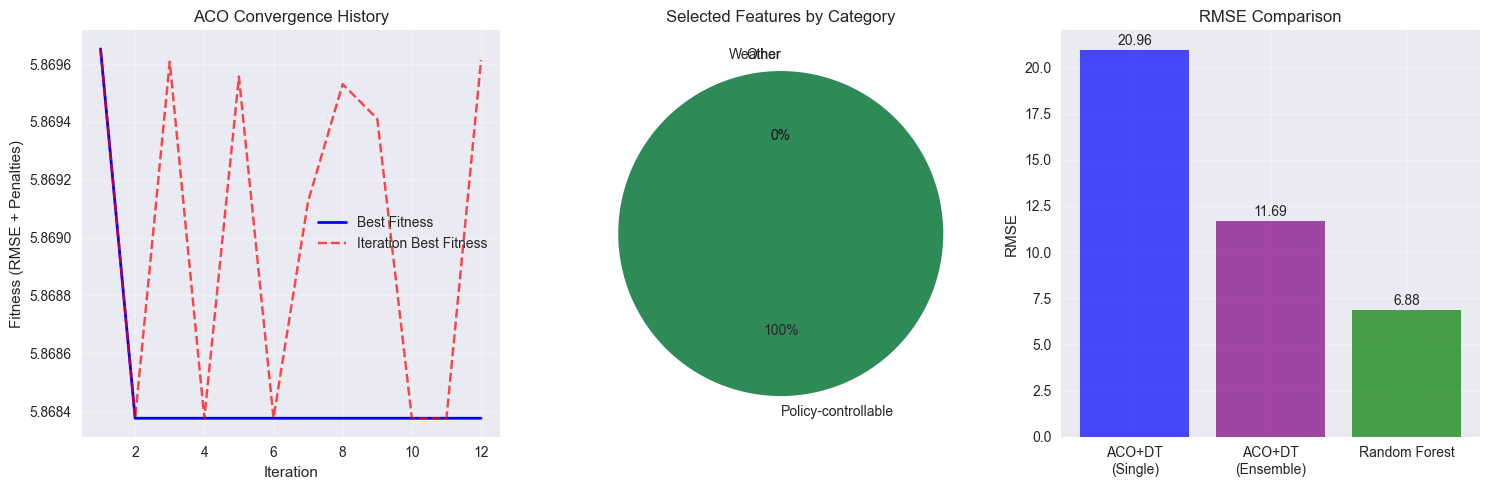

ACO analysis plot saved to ../results/plots/aco_analysis.png


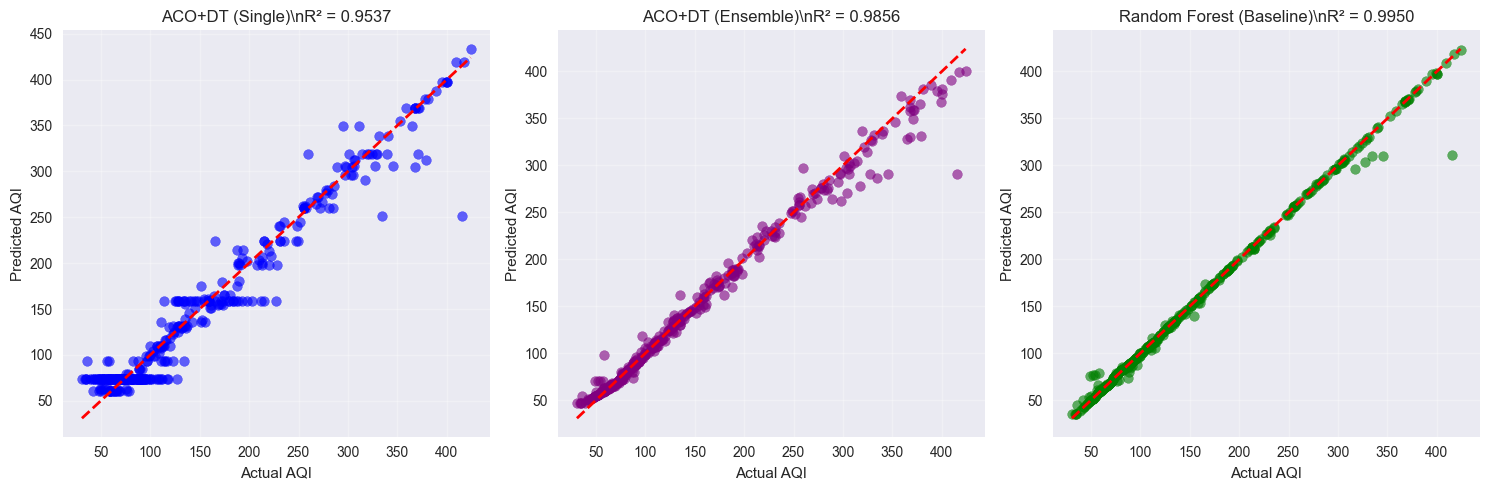

Prediction comparison plots saved to ../results/plots/prediction_comparison.png


In [18]:
# Create Visualizations
print("Creating visualizations...")

# Create ACO convergence visualization
plt.figure(figsize=(15, 5))

# Plot 1: Convergence history
plt.subplot(1, 3, 1)
iterations = [h['iteration'] for h in convergence_history]
best_fitness = [h['best_fitness'] for h in convergence_history]
iteration_fitness = [h['iteration_fitness'] for h in convergence_history]

plt.plot(iterations, best_fitness, 'b-', linewidth=2, label='Best Fitness')
plt.plot(iterations, iteration_fitness, 'r--', alpha=0.7, label='Iteration Best Fitness')
plt.xlabel('Iteration')
plt.ylabel('Fitness (RMSE + Penalties)')
plt.title('ACO Convergence History')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Feature selection comparison
plt.subplot(1, 3, 2)
feature_counts = {
    'Policy-controllable': sum(1 for f in best_features if any(pollutant in f for pollutant in aco_optimizer.policy_controllable)),
    'Weather': sum(1 for f in best_features if any(weather in f.lower() for weather in ['temperature', 'humidity', 'wind', 'pressure'])),
    'Other': len(best_features) - sum(1 for f in best_features if any(pollutant in f for pollutant in aco_optimizer.policy_controllable)) - sum(1 for f in best_features if any(weather in f.lower() for weather in ['temperature', 'humidity', 'wind', 'pressure']))
}

colors = ['#2E8B57', '#FF6B6B', '#4ECDC4']
plt.pie(feature_counts.values(), labels=feature_counts.keys(), autopct='%1.0f%%', 
        colors=colors, startangle=90)
plt.title('Selected Features by Category')

# Plot 3: RMSE Comparison
plt.subplot(1, 3, 3)
models = ['ACO+DT\n(Single)', 'ACO+DT\n(Ensemble)', 'Random Forest']
rmse_values = [rmse_dt, rmse_dt_ens, rmse_rf]
colors = ['blue', 'purple', 'green']
bars = plt.bar(models, rmse_values, color=colors, alpha=0.7)
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()

# Create results directory if it doesn't exist
os.makedirs('../results/plots', exist_ok=True)
plt.savefig('../results/plots/aco_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("ACO analysis plot saved to ../results/plots/aco_analysis.png")

# Create prediction comparison visualization
plt.figure(figsize=(15, 5))

# Plot 1: Prediction vs Actual (ACO+DT Single)
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_dt_aco, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title(f'ACO+DT (Single)\\nR² = {r2_dt:.4f}')
plt.grid(True, alpha=0.3)

# Plot 2: Prediction vs Actual (ACO+DT Ensemble)
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_dt_aco_ensemble, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title(f'ACO+DT (Ensemble)\\nR² = {r2_dt_ens:.4f}')
plt.grid(True, alpha=0.3)

# Plot 3: Prediction vs Actual (Random Forest)
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title(f'Random Forest (Baseline)\\nR² = {r2_rf:.4f}')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/prediction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Prediction comparison plots saved to ../results/plots/prediction_comparison.png")


In [19]:
# Save Results and Display Final Summary
print("Saving results and models...")

# Create results directory if it doesn't exist
os.makedirs('../results/models', exist_ok=True)
os.makedirs('../results/reports', exist_ok=True)

# Save enhanced models
joblib.dump(dt_aco, '../results/models/dt_aco_single_model.pkl')
joblib.dump(dt_aco_ensemble, '../results/models/dt_aco_ensemble_model.pkl')
joblib.dump(rf_baseline, '../results/models/rf_baseline_model.pkl')
joblib.dump(best_features, '../results/models/aco_selected_features.pkl')

# Save results summary
results_summary = {
    'model_comparison': {
        'aco_dt_single': {
            'rmse': float(rmse_dt),
            'mae': float(mae_dt),
            'r2': float(r2_dt),
            'custom_accuracy': float(acc_dt),
            'features_used': int(len(best_features))
        },
        'aco_dt_ensemble': {
            'rmse': float(rmse_dt_ens),
            'mae': float(mae_dt_ens),
            'r2': float(r2_dt_ens),
            'custom_accuracy': float(acc_dt_ens),
            'features_used': int(len(best_features))
        },
        'random_forest': {
            'rmse': float(rmse_rf),
            'mae': float(mae_rf),
            'r2': float(r2_rf),
            'custom_accuracy': float(acc_rf),
            'features_used': int(len(feature_columns))
        }
    },
    'feature_selection': {
        'total_features': int(len(feature_columns)),
        'selected_features': int(len(best_features)),
        'feature_reduction_percent': float((len(feature_columns) - len(best_features)) / len(feature_columns) * 100),
        'policy_controllable_selected': int(sum(1 for f in best_features if any(pollutant in f for pollutant in aco_optimizer.policy_controllable))),
        'selected_feature_list': best_features
    },
    'performance_difference': {
        'aco_dt_single': {
            'rmse_difference': float(rmse_dt - rmse_rf),
            'rmse_difference_percent': float((rmse_dt - rmse_rf) / rmse_rf * 100),
            'within_5_percent_target': bool(abs(rmse_dt - rmse_rf) / rmse_rf <= 0.05)
        },
        'aco_dt_ensemble': {
            'rmse_difference': float(rmse_dt_ens - rmse_rf),
            'rmse_difference_percent': float((rmse_dt_ens - rmse_rf) / rmse_rf * 100),
            'within_5_percent_target': bool(abs(rmse_dt_ens - rmse_rf) / rmse_rf <= 0.05)
        },
        'best_aco_model': {
            'model_type': best_model,
            'best_rmse': float(best_rmse),
            'target_achieved': bool(target_achieved)
        }
    }
}

# Save as JSON
with open('../results/reports/aco_results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Results saved successfully!")
print(f"Models saved to: ../results/models/")
print(f"Results summary saved to: ../results/reports/aco_results_summary.json")

# Display final summary
print(f"\n" + "="*60)
print("ACO+DT IMPLEMENTATION SUMMARY")
print("="*60)
print(f"Total features available: {len(feature_columns)}")
print(f"Features selected by ACO: {len(best_features)}")
print(f"Feature reduction: {((len(feature_columns) - len(best_features)) / len(feature_columns) * 100):.1f}%")
print(f"Policy-controllable features selected: {sum(1 for f in best_features if any(pollutant in f for pollutant in aco_optimizer.policy_controllable))}")
print(f"\nPerformance:")
print(f"  ACO+DT (Single) RMSE: {rmse_dt:.2f}")
print(f"  ACO+DT (Ensemble) RMSE: {rmse_dt_ens:.2f}")
print(f"  Random Forest RMSE: {rmse_rf:.2f}")
print(f"  Best ACO+DT model: {best_model}")
print(f"  Best performance difference: {((best_rmse - rmse_rf) / rmse_rf * 100):+.1f}%")
print(f"  Within 5% target: {'YES' if target_achieved else 'NO'}")
print("="*60)


Saving results and models...
Results saved successfully!
Models saved to: ../results/models/
Results summary saved to: ../results/reports/aco_results_summary.json

ACO+DT IMPLEMENTATION SUMMARY
Total features available: 48
Features selected by ACO: 8
Feature reduction: 83.3%
Policy-controllable features selected: 8

Performance:
  ACO+DT (Single) RMSE: 20.96
  ACO+DT (Ensemble) RMSE: 11.69
  Random Forest RMSE: 6.88
  Best ACO+DT model: Ensemble DT
  Best performance difference: +69.9%
  Within 5% target: NO
